In [1]:
import json
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer, losses
from torch.utils.data import DataLoader
from sentence_transformers.readers import InputExample
import os
import re
import random
from collections import defaultdict
from sklearn.model_selection import train_test_split

/home/sagemaker-user/.conda/envs/rapids-25.02/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Create Training Data

In [2]:
def extract_keys(template):
    keys = re.findall(r"{(.*?)}", template)
    return keys


def get_dictionary_from_folders(directory_path: str):
    json_dict = {}

    for filename in os.listdir(directory_path):
        if filename.endswith(".json"):
            file_path = os.path.join(directory_path, filename)

            with open(file_path, "r") as file:
                json_content = json.load(file)

            key = os.path.splitext(filename)[0]

            json_dict[key] = json_content

    return json_dict
    
mappings = get_dictionary_from_folders("/home/sagemaker-user/chatrd/scripts/uc_embedding_generation/template_values")
template_values = get_dictionary_from_folders("/home/sagemaker-user/chatrd/scripts/uc_embedding_generation/templates")

def generate_questions(mappings, template_values, num_runs, K):
    questions = {}
    n_timer = defaultdict(lambda: 1, {key : K // len(template_values[key]) for key in template_values.keys()})
    for key, values in template_values.items():
        templates = values
        for template in templates:
            unique_questions = set()
            N = num_runs * n_timer[key]
            for _ in range(N):
                present_keys = extract_keys(template)
                all_pairs = {}
                for mp_key in present_keys:
                    all_pairs[mp_key] = random.choice(
                        mappings[mp_key],
                    )
                # print(template)
                question = template.format(**all_pairs)
                unique_questions.add(question)
            if key in questions:
                questions[key].extend(list(unique_questions))
            else:
                questions[key] = list(unique_questions)
    return questions

In [3]:
questions = generate_questions(mappings, template_values, 1, 500)
keys = questions.keys()
question_bank = generate_questions(mappings, template_values, 5, 500)
validation_bank = generate_questions(mappings, template_values, 1, 500)
full_question_bank = [q for key in keys for q in question_bank[key]];
q_l = [(q, cat) for cat in questions.keys() for q in questions[cat]]
q_v = [(q, cat) for cat in validation_bank.keys() for q in validation_bank[cat]]

In [4]:
anchors = []
positives = []
negatives = []
keys = questions.keys()
for key1 in keys:
    for key2 in keys:
        if key1 == key2:
            pass
        anchor = questions[key1]
        positive = np.random.choice(question_bank[key1], len(anchor))
        negative = np.random.choice(question_bank[key2], len(anchor))
        anchors.extend(anchor)
        positives.extend(positive)
        negatives.extend(negative)
# Incorporate user queries in training
# user_df = pd.read_csv("user_query_rephrased.csv").dropna()
# anchors.extend(user_df.questions.to_list())
# positives.extend(user_df.rephrased.to_list())
# negatives.extend(np.random.choice(full_question_bank, len(user_df)))

In [5]:
len(anchors)

105024

In [6]:
# Kb = 1000 / 13
# key_pairs = []
# [key_pairs.append((key1, key2)) if (key2, key1) not in key_pairs else None for key1 in questions.keys() for key2 in questions.keys()]
# cross_comparisons = []
# for (key1, key2) in key_pairs:
#     qs1 = np.random.choice(questions[key1], int(Kb))
#     qs2 = np.random.choice(questions[key2], int(Kb)) 
#     cross_comparisons.extend([InputExample(texts=[q1, q2], label=key1 == key2) for (q1, q2) in zip(qs1, qs2)])

In [7]:
from sklearn.preprocessing import LabelEncoder
from sentence_transformers import SentenceTransformer, SentenceTransformerTrainer, losses, SentenceTransformerTrainingArguments

In [8]:
from datasets import Dataset, DatasetInfo

dataset = Dataset.from_dict({
    "anchor": anchors,
    "positive": positives,
    "negative" : negatives,
})

In [9]:
train_test_split = dataset.train_test_split(test_size=0.2)
train_dataset = train_test_split['train']
test_dataset = train_test_split['test']

# Model and Training Instantiation

In [10]:
args = SentenceTransformerTrainingArguments(
    # Required parameter:
    output_dir="/home/sagemaker-user/embedding_finetune/mbert_model",
    # Optional training parameters:
    num_train_epochs=2,
    per_device_train_batch_size=128,
    per_device_eval_batch_size=128,
    warmup_ratio=0.1,
    fp16=False,  # Set to False if you get an error that your GPU can't run on FP16
    bf16=True,  # Set to True if you have a GPU that supports BF16
    # Optional tracking/debugging parameters:
    eval_strategy="steps",
    eval_steps=500,
    save_strategy="steps",
    save_steps=500,
    save_total_limit=2,
    logging_steps=500,
    report_to="none"
)

In [11]:
from sentence_transformers.util import euclidean_sim

In [12]:
from peft import LoraConfig, TaskType, BoneConfig
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('nomic-ai/modernbert-embed-base')
peft_config = BoneConfig(
    task_type=TaskType.FEATURE_EXTRACTION,
    inference_mode=False,
    r=8,
    # Needs to be dense layer names of model.
    target_modules={'Wqkv', 'Wo', 'Wi'}
)
# peft_config = LoraConfig(
#     task_type=TaskType.FEATURE_EXTRACTION,
#     inference_mode=False,
#     r=12,
#     # lora_alpha=48,
#     # lora_dropout=0.1,
#     target_modules=target_modules
# )
model.add_adapter(peft_config)

In [13]:
list(model.named_modules())

[('',
  SentenceTransformer(
    (0): Transformer({'max_seq_length': 8192, 'do_lower_case': False}) with Transformer model: ModernBertModel 
    (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
    (2): Normalize()
  )),
 ('0',
  Transformer({'max_seq_length': 8192, 'do_lower_case': False}) with Transformer model: ModernBertModel ),
 ('0.auto_model',
  ModernBertModel(
    (embeddings): ModernBertEmbeddings(
      (tok_embeddings): Embedding(50368, 768, padding_idx=50283)
      (norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (drop): Dropout(p=0.0, inplace=False)
    )
    (layers): ModuleList(
      (0): ModernBertEncoderLayer(
        (attn_norm): Identity()
        (attn): ModernBertAttention(
          (Wqkv): bone.BoneLine

In [14]:
train_loss = losses.MultipleNegativesRankingLoss(model=model, similarity_fct=euclidean_sim, scale = 2)# mini_batch_size = 128)
mtrain_loss = losses.MatryoshkaLoss(loss = train_loss, model = model, matryoshka_dims=[64, 32, 16])
trainer = SentenceTransformerTrainer(
    model=model,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    loss=mtrain_loss,
    args = args
)
trainer.train()

TrainOutput(global_step=1314, training_loss=10.97916462287148, metrics={'train_runtime': 835.5991, 'train_samples_per_second': 201.099, 'train_steps_per_second': 1.573, 'total_flos': 0.0, 'train_loss': 10.97916462287148, 'epoch': 2.0})

In [15]:
import datetime
model_save_path = "./models/modern_bert_bone_lora" + datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
model.save_pretrained(model_save_path)

# Diagnostics

In [16]:
bbq, catb = zip(*q_l)

In [17]:
base_qs, cats = zip(*q_v)
eX = model.encode(base_qs)

## PCA

Text(0.5, 1.0, 'Explained Variance of PCA Components')

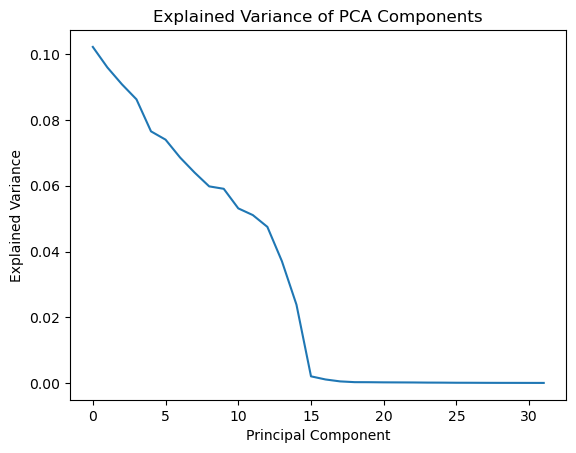

In [18]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, BisectingKMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.metrics import homogeneity_completeness_v_measure
from sklearn.preprocessing import LabelEncoder
pca = PCA(n_components=384)
pca.fit(eX)
fig, ax = plt.subplots()
ax.plot(pca.explained_variance_ratio_[0:32])
ax.set_xlabel("Principal Component")
ax.set_ylabel("Explained Variance")
ax.set_title("Explained Variance of PCA Components")


In [19]:
le = LabelEncoder()
Fy = le.fit_transform(cats)

In [20]:
xh = eX
fy = Fy

## KNN with cluster centers accuracy test

Test of accuracy on validation set.

In [21]:
from cuml.cluster import KMeans
from cuml import UMAP
import sklearn
from torch.nn import functional as F
import torch
from scipy.stats import mode
from sklearn.neighbors import KNeighborsClassifier

In [22]:
knn_q = generate_questions(mappings, template_values, 1, 500)
keys = list(knn_q.keys())
qs, cats = zip(*[(q, key) for key in keys for q in knn_q[key]])
le = LabelEncoder()
y = le.fit_transform(cats)
# x = model.encode(qs)
tqx, TqX, ty, TY = sklearn.model_selection.train_test_split(qs, y, shuffle=True)

In [23]:
len(tqx), len(TqX)

(4929, 1643)

In [24]:
tx, TX = model.encode(tqx), model.encode(TqX)
# tx, TX = F.normalize(torch.Tensor(tx), p=2, dim=1).detach().numpy(), F.normalize(torch.Tensor(TX), p=2, dim=1).detach().numpy()
dim = 64
tldx = tx[:, :dim]

In [25]:
dim = 64
tldx = tx[:, :dim]
km = KMeans(n_clusters = 300)
km.fit(tldx)
kyh = km.predict(tldx)
lyh = np.asarray([mode(ty[kyh == k])[0] if (kyh == k).sum() != 0 else -1 for k in range(km.n_clusters)]) 
knn_ld_km = KNeighborsClassifier(n_neighbors = 1)
knn_ld_km.fit(km.cluster_centers_, lyh)
knn_ld_km.score(TX[:, :dim], TY)

/home/sagemaker-user/.conda/envs/rapids-25.02/lib/python3.12/site-packages/cuml/internals/api_decorators.py:195: FutureWarning: The default value of `n_init` will change from 1 to 'auto' in 25.04. Set the value of `n_init` explicitly to suppress this warning.
  return func(*args, **kwargs)
/home/sagemaker-user/.conda/envs/rapids-25.02/lib/python3.12/site-packages/cuml/internals/api_decorators.py:193: FutureWarning: The default value of `n_init` will change from 1 to 'auto' in 25.04. Set the value of `n_init` explicitly to suppress this warning.
  ret = func(*args, **kwargs)


0.9975654290931223

## Clustering Metrics

In [26]:
obs = []
for k in range(3, 40, 1):
    for i in range(10):
        km = KMeans(n_clusters=k, random_state=random.randint(0, 1000), n_init='auto')
        inds = np.random.choice(xh.shape[0], 5000)
        sxh = xh[inds, :]
        km.fit(sxh)
        yh = km.predict(sxh)
        obs.append([k, silhouette_score(sxh, yh), *homogeneity_completeness_v_measure(fy[inds], yh)])
    print(k, end = '\r')

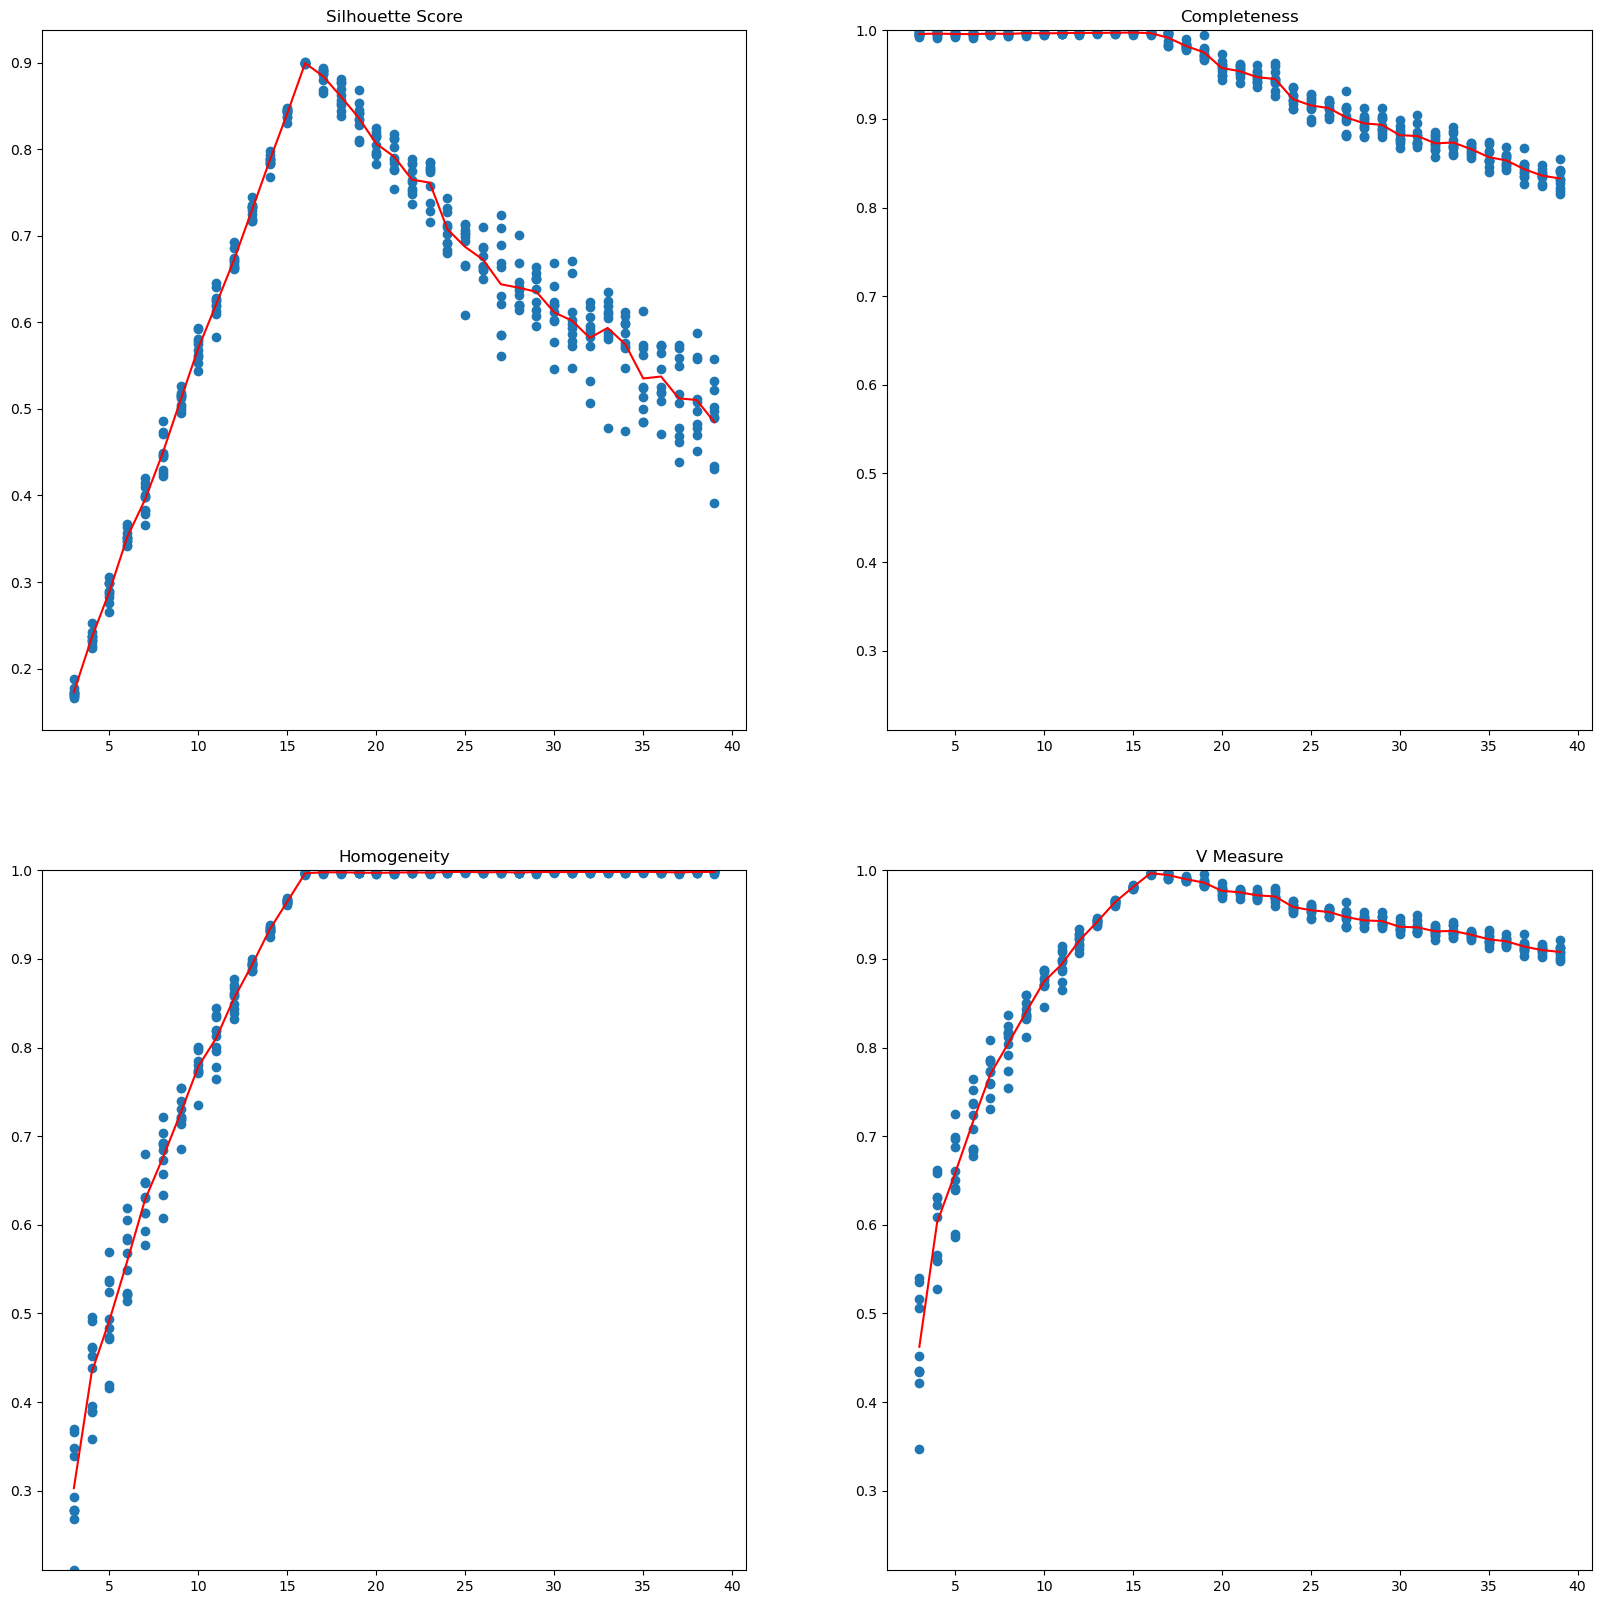

In [27]:
df = pd.DataFrame(obs, columns = ['k', 'sil', 'h', 'c', 'v'])
mv = df.groupby('k').mean()


fig, axs = plt.subplots(2, 2, figsize=(20, 20))
axs[0, 0].scatter(df['k'], df['sil'])
axs[0, 0].set_title('Silhouette Score')
axs[0, 0].plot(mv.index , mv['sil'], color = 'red')

ymin = df[['h', 'c', 'v']].min().min()
ymax = df[['h', 'c', 'v']].max().max()

axs[1, 0].scatter(df['k'], df['h'])
axs[1, 0].set_title('Homogeneity')
axs[1, 0].set_ylim(ymin, ymax)
axs[1, 0].plot(mv.index , mv['h'], color = 'red')

axs[0, 1].scatter(df['k'], df['c'])
axs[0, 1].set_title('Completeness')
axs[0, 1].set_ylim(ymin, ymax)
axs[0, 1].plot(mv.index , mv['c'], color = 'red')

axs[1, 1].scatter(df['k'], df['v'])
axs[1, 1].set_title('V Measure')
axs[1, 1].set_ylim(ymin, ymax)
axs[1, 1].plot(mv.index , mv['v'], color = 'red')

In [28]:
import altair as alt
alt.data_transformers.enable("vegafusion")

DataTransformerRegistry.enable('vegafusion')

In [29]:
km = KMeans(n_clusters = 20)
km.fit(xh)

/home/sagemaker-user/.conda/envs/rapids-25.02/lib/python3.12/site-packages/cuml/internals/api_decorators.py:195: FutureWarning: The default value of `n_init` will change from 1 to 'auto' in 25.04. Set the value of `n_init` explicitly to suppress this warning.
  return func(*args, **kwargs)


KMeans()

## UMAP Vis

In [30]:
import altair as alt
alt.data_transformers.enable("vegafusion")
# fig, ax = plt.subplots(1, 2, figsize=(20, 10))
dl = UMAP(
    n_components=2,
    min_dist = .5
).fit_transform(xh[:, 0:64])
glyph = pd.DataFrame()
glyph['x'] = dl[:, 0]
glyph['y'] = dl[:, 1]
glyph['label'] = le.inverse_transform(fy)
glyph['question'] = base_qs
# ax[0].scatter(dl[:, 0], dl[:, 1], label = fy, c = fy, cmap = 'tab20')
# ax[1].scatter(dl[:, 0], dl[:, 1], label = kyh, c = kyh, cmap = 'tab20')

right = alt.Chart(glyph).mark_circle(size=40).encode(
    x='x',
    y='y',
    color='label:N',
    tooltip = ['question', 'label']
).properties(
    width=500,
    height=500
).interactive()

right

[2025-04-01 15:05:51.949] [CUML] [info] Building knn graph using brute force


alt.Chart(...)